In [4]:
%pip install skyfield
%pip install itur


[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
from skyfield.api import Topos, load
from skyfield.api import EarthSatellite

In [6]:
planets = load('de421.bsp')
earth = planets['earth']

ts = load.timescale()

In [7]:
stations_url = 'https://www.celestrak.com/NORAD/elements/active.txt'
satellites = load.tle_file(stations_url, reload=True)
print('Loaded', len(satellites), 'satellites')

[#################################] 100% active.txt


Loaded 6789 satellites


In [8]:
by_name = {sat.name: sat for sat in satellites}
satellite = by_name['ASTROCAST 0.2']
print(satellite)

ASTROCAST 0.2 catalog #44083 epoch 2022-11-03 02:37:41 UTC


In [9]:
antenna_position = Topos(47.01452, 8.30613, elevation_m=500)
t0 = ts.now()
t1 = ts.utc(ts.now().utc.year, ts.now().utc.month, ts.now().utc.day + 1)
t, events = satellite.find_events(antenna_position, t0, t1, altitude_degrees=0.0)
t_rise = []
t_below = []
for ti, event in zip(t, events):
    name = ('rise above horizon', 'culminate', 'set below horizon')[event]
    print(ti.utc_strftime('%Y %b %d %H:%M:%S'), name)

2022 Nov 03 09:23:13 rise above horizon
2022 Nov 03 09:28:51 culminate
2022 Nov 03 09:34:27 set below horizon
2022 Nov 03 10:57:31 rise above horizon
2022 Nov 03 11:01:22 culminate
2022 Nov 03 11:05:15 set below horizon
2022 Nov 03 18:30:00 rise above horizon
2022 Nov 03 18:33:27 culminate
2022 Nov 03 18:36:55 set below horizon
2022 Nov 03 20:00:22 rise above horizon
2022 Nov 03 20:05:51 culminate
2022 Nov 03 20:11:25 set below horizon
2022 Nov 03 21:35:06 rise above horizon
2022 Nov 03 21:39:29 culminate
2022 Nov 03 21:43:56 set below horizon


In [10]:
difference = satellite - antenna_position
topocentric = difference.at(t0)
alt, az, distance = topocentric.altaz()

In [11]:
if alt.degrees > 0:
    print('The', satellite.name, 'is above the horizon')
else:
    #print(the time remaining until the next pass)
    pass

print('elevation =', alt)
print('azimuth =', az)
print(int(distance.km), 'km')

elevation = -82deg 00' 19.7"
azimuth = 340deg 21' 38.5"
13107 km


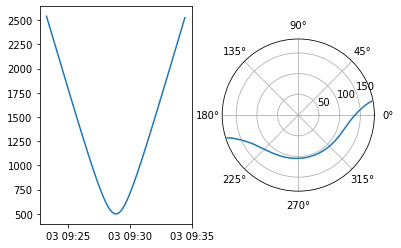

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter

#Fly
t_rise = t[0]
t_below = t[2]
difference = satellite - antenna_position
timeline = ts.linspace(t_rise, t_below, 1000)
alt, az, dist = difference.at(timeline).altaz()

fig = plt.figure()
ax = plt.subplot(1, 2, 1)
ax.plot(timeline.utc_datetime(), dist.km)

ax = plt.subplot(1, 2, 2, projection='polar')
ax.plot(az.radians, 180 - alt.degrees)

plt.savefig("fig_1.png")

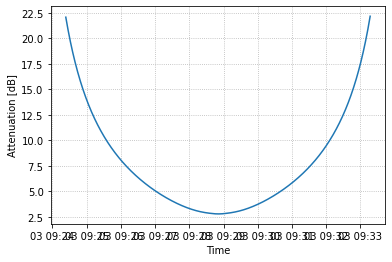

In [43]:
import itur
import astropy.units as u

f = 22.5 * u.GHz    # Link frequency
D = 0.4 * u.m       # Antenna diameters
p = 1               # Unavailability (Values exceeded 1% of time)
#print(antenna_position.latitude.degrees, antenna_position.longitude.degrees)
el_t = list(filter(lambda x: x[1] > 5, zip(timeline.utc_datetime(), alt.degrees)))
#print([x[1] for x in el_t])
Att = itur.atmospheric_attenuation_slant_path(antenna_position.latitude.degrees,
                                              antenna_position.longitude.degrees,
                                              f,
                                              [x[1] for x in el_t],
                                              p,
                                              D)
plt.figure()
plt.plot([x[0] for x in el_t], Att.value)
plt.xlabel('Time')
plt.ylabel('Attenuation [dB]')
plt.grid(which='major', linestyle=':')

plt.savefig("fig_2.png")